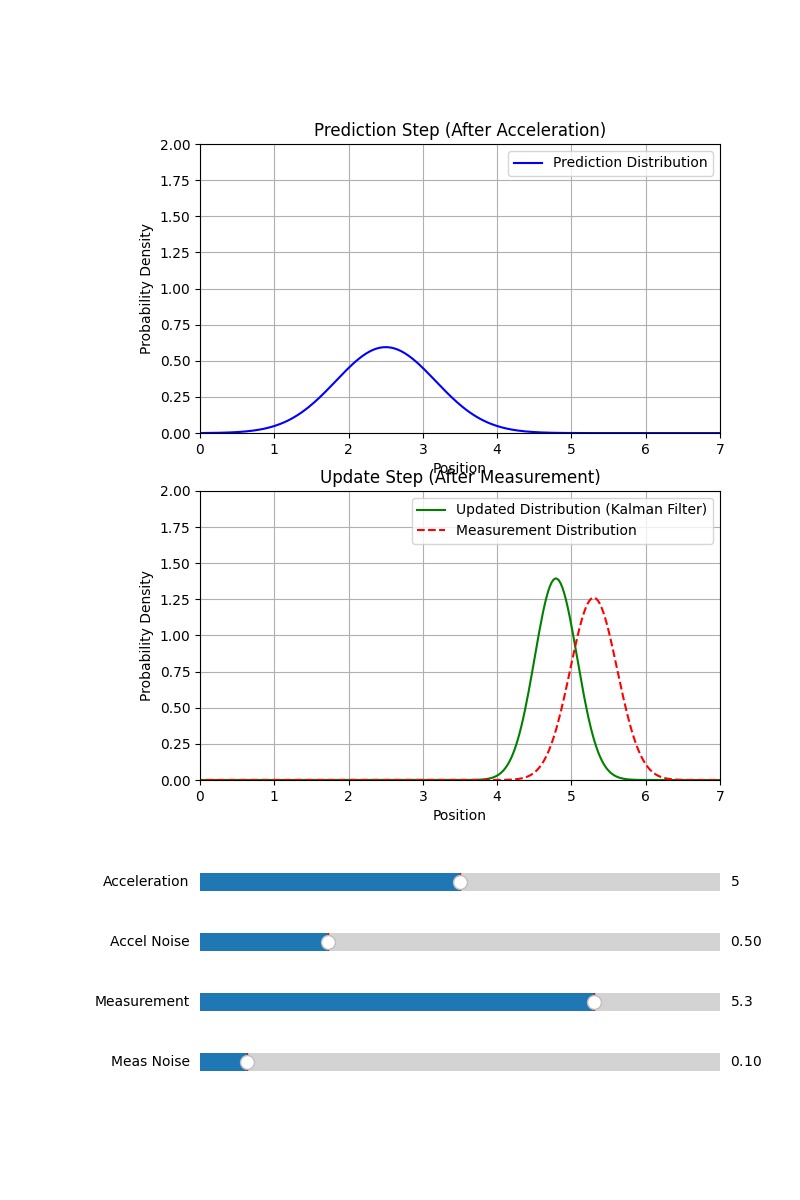

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

%matplotlib widget

# Function to calculate the Gaussian PDF
def gaussian_pdf(x, mean, variance):
    return (1 / np.sqrt(2 * np.pi * variance)) * np.exp(-0.5 * ((x - mean) ** 2) / variance)

# Kalman filter prediction step
def kalman_predict(position, velocity, acceleration, position_var, velocity_var, accel_noise_var, dt=1.0):
    # Predict the new position and velocity
    new_position = position + velocity * dt + 0.5 * acceleration * dt**2
    new_velocity = velocity + acceleration * dt
    
    # Update the variance (process noise added)
    new_position_var = position_var + velocity_var * dt + 0.5 * accel_noise_var * dt**2
    new_velocity_var = velocity_var + accel_noise_var * dt
    
    return new_position, new_velocity, new_position_var, new_velocity_var

# Kalman filter update step
def kalman_update(pred_mean, pred_var, meas_mean, meas_var):
    kalman_gain = pred_var / (pred_var + meas_var)
    updated_mean = kalman_gain * meas_mean + (1 - kalman_gain) * pred_mean
    updated_var = (1 - kalman_gain) * pred_var
    return updated_mean, updated_var, kalman_gain

# Initial parameters
initial_position = 0
initial_velocity = 0
initial_accel = 5
initial_accel_noise = 0.5
initial_meas_mean = 5.3
initial_position_var = 0.1
initial_velocity_var = 0.1
initial_meas_var = 0.1
positions = np.linspace(-2, 10, 500)

# Create figure and axes for two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))
plt.subplots_adjust(left=0.25, bottom=0.35)

# Predict the next position based on acceleration
predicted_position, predicted_velocity, predicted_position_var, _ = kalman_predict(
    initial_position, initial_velocity, initial_accel, initial_position_var, initial_velocity_var, initial_accel_noise
)
pred_pdf = gaussian_pdf(positions, predicted_position, predicted_position_var)
line_pred, = ax1.plot(positions, pred_pdf, label='Prediction Distribution', color='blue')
ax1.set_title('Prediction Step (After Acceleration)')
ax1.set_xlabel('Position')
ax1.set_ylabel('Probability Density')
ax1.set_ylim((0, 2))
ax1.set_xlim((0, 7))
ax1.grid(True)
ax1.legend()

# Update the position estimate with the measured value
updated_position, updated_var, kalman_gain = kalman_update(predicted_position, predicted_position_var, initial_meas_mean, initial_meas_var)
updated_pdf = gaussian_pdf(positions, updated_position, updated_var)
meas_pdf = gaussian_pdf(positions, initial_meas_mean, initial_meas_var)
line_updated, = ax2.plot(positions, updated_pdf, label='Updated Distribution (Kalman Filter)', color='green')
line_measured, = ax2.plot(positions, meas_pdf, label='Measurement Distribution', color='red', linestyle='--')

ax2.set_title('Update Step (After Measurement)')
ax2.set_xlabel('Position')
ax2.set_ylabel('Probability Density')
ax2.set_ylim((0, 2))
ax2.set_xlim((0, 7))
ax2.grid(True)
ax2.legend()

# Add sliders for user input
ax_accel = plt.axes([0.25, 0.25, 0.65, 0.03])
ax_accel_noise = plt.axes([0.25, 0.20, 0.65, 0.03])
ax_meas_mean = plt.axes([0.25, 0.15, 0.65, 0.03])
ax_meas_noise = plt.axes([0.25, 0.10, 0.65, 0.03])

slider_accel = Slider(ax_accel, 'Acceleration', 0.0, 10.0, valinit=initial_accel)
slider_accel_noise = Slider(ax_accel_noise, 'Accel Noise', 0.01, 2.0, valinit=initial_accel_noise)
slider_meas_mean = Slider(ax_meas_mean, 'Measurement', 0.0, 7.0, valinit=initial_meas_mean)
slider_meas_noise = Slider(ax_meas_noise, 'Meas Noise', 0.01, 1.0, valinit=initial_meas_var)

# Update function for interactive plot
def update(val):
    accel = slider_accel.val
    accel_noise = slider_accel_noise.val
    meas_mean = slider_meas_mean.val
    meas_noise = slider_meas_noise.val

    # Prediction step
    pred_position, pred_velocity, pred_position_var, _ = kalman_predict(
        initial_position, initial_velocity, accel, initial_position_var, initial_velocity_var, accel_noise
    )
    pred_pdf = gaussian_pdf(positions, pred_position, pred_position_var)
    line_pred.set_ydata(pred_pdf)

    # Update step (Kalman filter update)
    updated_position, updated_var, kalman_gain = kalman_update(pred_position, pred_position_var, meas_mean, meas_noise)
    updated_pdf = gaussian_pdf(positions, updated_position, updated_var)
    line_updated.set_ydata(updated_pdf)

    # Update measurement distribution
    meas_pdf = gaussian_pdf(positions, meas_mean, meas_noise)
    line_measured.set_ydata(meas_pdf)

    fig.canvas.draw_idle()

# Connect sliders to the update function
slider_accel.on_changed(update)
slider_accel_noise.on_changed(update)
slider_meas_mean.on_changed(update)
slider_meas_noise.on_changed(update)

plt.show()